# Conservation Analysis and Epitope Prediction


#### Author: C. Mazzaferro, K. Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: August 2016
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#ConsA">Conservation Analysis</a>
    * <a href = "#BLAST">BLAST-P</a>
    * <a href = "#MSA">Multiple Sequence Alignment</a>
    * <a href = "#Cons">Conservation Score Prediction</a>
3. <a href = "#ep_pred">Windowing and New Epitope Prediction</a>
    * <a href = "#clustering">Epitope Clustering Analysis</a>

1. Run netMHCcons on full protein  DONE
2. Extract n-merized peptides   DONE
3. Calculate conservation score based on specific peptide   DONE
4. Peptide T-Cell receptor binding]    
5. Per Protein Metrics
 - high affinity peptides 
 - medium affinity peptides
 - "AVG" immunological values
    
    
>Summaries

>By protein

>Overall summary 


Screenshots
Peptide Summary: pep score affinty, verbal summary, high affinity and conserved/not conserved
Clustal Alignment with extra data (cons, affinity)
Clustal Alignment with the high affinity low conservation parts
Immunogenicity of potential "swap" parts

<a id = "background"></a>
# Background

CRISPR (clustered regularly interspaced short palindromic repeat) is an adaptive immune system that provides protection against mobile genetic elements (viruses, transposable elements and conjugative plasmids).
CRISPR clusters contain spacers, sequences complementary to antecedent mobile elements, and target invading nucleic acids. CRISPR clusters are transcribed and processed into CRISPR RNA (crRNA). In type II CRISPR systems correct processing of pre-crRNA requires a trans-encoded small RNA (tracrRNA), endogenous ribonuclease 3 (rnc) and this protein. The tracrRNA serves as a guide for ribonuclease 3-aided processing of pre-crRNA; Cas9 only stabilizes the pre-crRNA:tracrRNA interaction and has no catalytic function in RNA processing. Subsequently Cas9/crRNA/tracrRNA endonucleolytically cleaves linear or circular dsDNA target complementary to the spacer; Cas9 is inactive in the absence of the 2 guide RNAs (gRNA). The target strand not complementary to crRNA is first cut endonucleolytically, then trimmed 3'-5' exonucleolytically. DNA-binding requires protein and both gRNAs, as does nuclease activity. Cas9 recognizes the protospacer adjacent motif (PAM) in the CRISPR repeat sequences to help distinguish self versus nonself, as targets within the bacterial CRISPR locus do not have PAMs. DNA strand separation and heteroduplex formation starts at PAM sites; PAM recognition is required for catalytic activity (PubMed:24476820). Confers immunity against a plasmid with homology to the appropriate CRISPR spacer sequences (CRISPR interference) (PubMed:21455174)

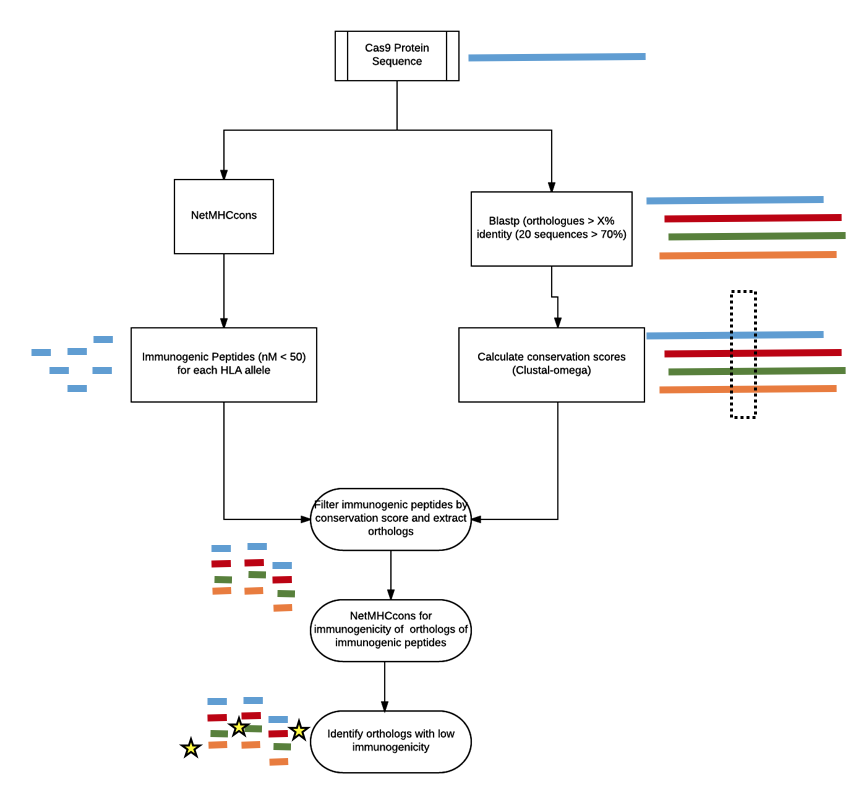

In [96]:
from IPython.display import Image
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/workflow_epitope.png")

The pipeline presented here is aimed at identify the most immunogenic peptides in Cas9. By looking at multiple sequence alignment scores for the possible peptides and their associated predicted MHC affinity, we can determine which peptides within a Cas9 orthologue can be swapped in order to reduce overall immunogenecity.

The steps are constructed as follows: 

1. Select proteins [from reference papaer](http://nar.oxfordjournals.org/content/suppl/2013/10/29/gkt1074.DC1/nar-02672-z-2013-File008.pdf)
2. Peform Multiple Sequence Alignement (MSA) using locally installed [Clustal Omega](http://www.clustal.org/omega/) in order to determine conservation scores
3. Calculate conservation scores for each n-mer (sizes 9, 10, 11) of the MSA
4. Predict the MHC affinity of each peptide using [CBS's prediction services](http://www.cbs.dtu.dk/services/), in particular [netMHCcons Server](http://www.cbs.dtu.dk/services/NetMHCcons/)
5. Output list of highly low-conservation, high affinity peptides for in-vitro research

<a id = "ConsA"></a>
# Conservation Analysis

The package nepitope is used as a "glue" between the steps involved in epitope prediction analysis. It was designed specifically to enable the user to run the steps outlined in "Background" and rendering the inputs and outputs of each program compatible for each step. 


<a id = "BLAST"></a>
## Protein Selection
Protein sequences were extracted from the paper referenced in bullet point #1

In [1]:
import glob
import pandas
from nepitope import preprocessing, scoring_utils
prots = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/page*'

files = glob.glob(prots)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [3]:
ls_df = preprocessing.join_files(files)    
preprocessing.test_consistency(ls_df)

my_series = preprocessing.concat_dfs(ls_df)
preprocessing.test_series_consistency(my_series)

Grab extra data (motifs, JNET, secondary structure). Saved on file:  /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/extra_data_from_study.txt

In [4]:
extra_data = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/extra_data_from_study.txt'
motifs, inf_pos = preprocessing.load_motifs_and_conservation_locs(extra_data)        

###  Dealign and rerun Clustal with reference protein sequence added

#### Write out as as single lines, dealign, add ref protein at the bottom

In [5]:
prop_form_fasta = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_proper.fasta'
Reference_Protein_name = '>StreptococcusPyogenes_reference'
Reference_Protein = 'MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRRKNRICYLQEIFSNEMAKVDDSFFHRLEESFLVEEDKKHERHPIFGNIVDEVAYHEKYPTIYHLRKKLVDSTDKADLRLIYLALAHMIKFRGHFLIEGDLNPDNSDVDKLFIQLVQTYNQLFEENPINASGVDAKAILSARLSKSRRLENLIAQLPGEKKNGLFGNLIALSLGLTPNFKSNFDLAEDAKLQLSKDTYDDDLDNLLAQIGDQYADLFLAAKNLSDAILLSDILRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFDQSKNGYAGYIDGGASQEEFYKFIKPILEKMDGTEELLVKLNREDLLRKQRTFDNGSIPHQIHLGELHAILRRQEDFYPFLKDNREKIEKILTFRIPYYVGPLARGNSRFAWMTRKSEETITPWNFEEVVDKGASAQSFIERMTNFDKNLPNEKVLPKHSLLYEYFTVYNELTKVKYVTEGMRKPAFLSGEQKKAIVDLLFKTNRKVTVKQLKEDYFKKIECFDSVEISGVEDRFNASLGTYHDLLKIIKDKDFLDNEENEDILEDIVLTLTLFEDREMIEERLKTYAHLFDDKVMKQLKRRRYTGWGRLSRKLINGIRDKQSGKTILDFLKSDGFANRNFMQLIHDDSLTFKEDIQKAQVSGQGDSLHEHIANLAGSPAIKKGILQTVKVVDELVKVMGRHKPENIVIEMARENQTTQKGQKNSRERMKRIEEGIKELGSQILKEHPVENTQLQNEKLYLYYLQNGRDMYVDQELDINRLSDYDVDHIVPQSFLKDDSIDNKVLTRSDKNRGKSDNVPSEEVVKKMKNYWRQLLNAKLITQRKFDNLTKAERGGLSELDKAGFIKRQLVETRQITKHVAQILDSRMNTKYDENDKLIREVKVITLKSKLVSDFRKDFQFYKVREINNYHHAHDAYLNAVVGTALIKKYPKLESEFVYGDYKVYDVRKMIAKSEQEIGKATAKYFFYSNIMNFFKTEITLANGEIRKRPLIETNGETGEIVWDKGRDFATVRKVLSMPQVNIVKKTEVQTGGFSKESILPKRNSDKLIARKKDWDPKKYGGFDSPTVAYSVLVVAKVEKGKSKKLKSVKELLGITIMERSSFEKNPIDFLEAKGYKEVKKDLIIKLPKYSLFELENGRKRMLASAGELQKGNELALPSKYVNFLYLASHYEKLKGSPEDNEQKQLFVEQHKHYLDEIIEQISEFSKRVILADANLDKVLSAYNKHRDKPIREQAENIIHLFTLTNLGAPAAFKYFDTTIDRKRYTSTKEVLDATLIHQSITGLYETRIDLSQLGGD'
dealigned_ = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_dealigned.fasta'

preprocessing.dealign_and_add_reference_protein(prop_form_fasta, dealigned_, Reference_Protein, Reference_Protein_name)

### Run Clustal Omega on dealigned sequence 
(And hope it won't mess up too much the alignment)

In [142]:
!clustalo -i /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_dealigned.fasta --residuenumber -o /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study.fasta --outfmt=fasta

### Visualize old and new alignments

In [1]:
!mview -in fasta -ruler on -html head -coloring any /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_from_study_proper.fasta > /Users/carlomazzaferro/Documents/Code/clustal_study.html

/bin/sh: mview: command not found


In [35]:
import os
import webbrowser
from urllib import request         

url_old = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_study.html")))
url_new = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_studt_realigned.html")))
webbrowser.open(url_old)
webbrowser.open(url_new)

True

Clearly the old assignment is different from the new one. Hence, the positional information will have to be realigned. Let's get creative to see how to get this done.

## Conserved Positions

Can be retrieved from original alignment file, now saved as `inf_pos`

In [1]:
import numpy as np
import pandas
from nepitope import scoring_utils
from skbio import TabularMSA, Protein
msa_file = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC.fasta'
ref_prot = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/aligned_streptococcus.fasta'

my_algn = scoring_utils.Alignment(msa_file, ref_prot)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


Some attributes and methods:

In [2]:
my_algn.msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 87
    position count: 3710
-----------------------------------------------------------------------
XXXNYRIGIDVGLNSXXXXXXXXXXXIGFCAVE ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXDYSIGLDMGTSSXXXXXXXXXXXVGWAVTD ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
...
XXXILPIAIDLGVKNXXXXXXXXXXXTGVFSAF ... XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
MDKKYSIGLDIGTNSXXXXXXXXXXXVGWAVIT ... YTSTKEVLDATLIHQSITGLYETRIDLSQLGGD

In [3]:
my_algn.positional_conservation[10:20]

array([ 0.59785947,  1.        ,  0.45901451,  0.40179363,  0.87234284,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [4]:
my_algn.reference_protein_string[0:80]

'MDKKYSIGLDIGTNS-----------VGWAVITDEYKV---PSKKFKVLGNTDRHSIKKNLIGALLFDSGET-----AE-'

In [5]:
nmers = [8,9,10,11]
scores_df = my_algn.create_score_df_from_scikit_bio(nmers)
scores_df.head()

,Score,Peptide,n-mer
0,0,MDKKYSIG,8
1,0,DKKYSIGL,8
2,0.122423,KKYSIGLD,8
3,0.197156,KYSIGLDI,8
4,0.322156,YSIGLDIG,8


# MHC Binding Affinity Prediction 
### Ran on netMHCcons for n-mers of 8, 9, 10, 11 amino acids and for the 12 allele supertype families

Run for a specific protein sequence - in reality this step will be performed for as many proteins as possible. In this case, the following protein was used (retrieved from BLAST):
> sp|Q99ZW2|CAS9_STRP1 CRISPR-associated endonuclease Cas9/Csn1 OS=Streptococcus pyogenes serotype M1 GN=cas9 PE=1 SV=1`

#### Load file

In [6]:
from nepitope import scoring_utils
nmers = [8, 9,10,11]

#files saved from netMHCcons as split_*i*_prediction_*n*_mer for each split/nmer
filepath = '/Users/carlomazzaferro/Desktop/Test_IEDB/ful_prot_strepto.xls'

aggregate_all = scoring_utils.FileConsolidation.load_full_file(filepath)

#### Return data in a list of dataframes, where each dataframe contains data about a protein
(May take some time)
In this case we only used one protein for the prediction, namely the CAS9 Streptococcus Pyogegenes.

In [7]:
df1 = aggregate_all.return_df_list()
lsss = aggregate_all.list_df_by_prot(df1)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:608: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]


#### Viz data in first protein

In [8]:
lsss[0].sort_values(by='nM').head(10) #Some high affinity peps in protein BAV54116

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer
7312,0.879,3.70,0.01,3609,EIIEQISEF,StreptococcusPy,HLA-A26:01,High,9
7309,0.847,5.21,0.12,3606,YLDEIIEQI,StreptococcusPy,HLA-A02:01,High,9
3292,0.843,5.44,0.03,3292,REVKVITL,StreptococcusPy,HLA-B40:01,High,8
5965,0.840,5.65,0.15,2262,SLLYEYFTV,StreptococcusPy,HLA-A02:01,High,9
6026,0.808,7.94,0.10,2323,KAIVXDLLF,StreptococcusPy,HLA-B58:01,High,9
2263,0.806,8.11,0.30,2263,LLYEYFTV,StreptococcusPy,HLA-A02:01,High,8
6918,0.804,8.34,0.03,3215,EVVKKMKNY,StreptococcusPy,HLA-A26:01,High,9
14482,0.797,8.94,0.03,3376,KYFFYSNIMNF,StreptococcusPy,HLA-A24:02,High,11
9271,0.794,9.34,0.07,1866,GEXXXLHAIL,StreptococcusPy,HLA-B40:01,High,10
9541,0.793,9.39,0.40,2136,ILTFRIPYYV,StreptococcusPy,HLA-A02:01,High,10


#### Add conservation scores

In [9]:
#scores_df.loc[(scores_df['n-mer'] == 11) & (scores_df['Score'] > 0) & (scores_df['Peptide'].str.contains('-') == False)]
#lsss[0]['n-mer'].unique()
#scores_df.loc[scores_df['n-mer']==11]

In [10]:
scores_and_affinity = scoring_utils.Score.add_conserv_score_to_df_list(lsss, scores_df)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1['Score'] = list_1


In [11]:
scores_and_affinity[0].loc[scores_and_affinity[0]['n-mer'] == 8].head(5)
# (Affinity Score U Cons Scorezx)

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer,Score
0,0.043,31229.48,50.0,0,MDKKYSIG,StreptococcusPy,HLA-A01:01,No,8,0.000000
1,0.043,31229.48,50.0,1,DKKYSIGL,StreptococcusPy,HLA-A01:01,No,8,0.000000
2,0.041,32085.75,50.0,2,KKYSIGLD,StreptococcusPy,HLA-A01:01,No,8,0.122423
3,0.053,28026.90,50.0,3,KYSIGLDI,StreptococcusPy,HLA-A01:01,No,8,0.197156
4,0.068,24087.38,32.0,4,YSIGLDIG,StreptococcusPy,HLA-A01:01,No,8,0.322156


In [12]:
## Save as csv
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/protein_data_per_peptide.csv'
scores_and_affinity[0].to_csv(path_or_buf=csv_path, sep=',')

# Data Summary
The class SummaryData has two classmethods: summarize_all_data, and summarize_protein data. 
The first takes as input the entire list of dataframes retrived from the previous steps, while the second takes that alongside with the accession ID of a protein of choice. 

The main method implemented alogside with the first classmethod is return_dataframe. It will return a dataframe that summarizes key information for each protein. 

With summarize_protein_data, summary information regarding a specific protein is retrieved. Methods for plotting conservation scores against affinity levels are also present.

The object single protein can be interrogated in a variety of manners:
Attributes of single_prot:

- my_protein (protein name)
- title (alignment title)
- high_affinity_peps (number of high affinity peptides)
- med_affinity_peps (number of intermediate affinity peptides)
- low_affinity_peps (number of low affinity peptides)
- no_affinity_peps (number of no affinity peptides)
- high_affinity_per_aa (num high affinity peptides per amino acid (protein length))
- length (protein length)
- single_hits (bumber of hits in blast alignemnt)

Most importantly, the class also has the attribute my_df, that is the original dataframe the contains the data for each specific peptide inside the protein. The data contained in it can also be used to generate useful plots.

Firstly, save raw summary data to csv. 

-------------------------------  ---------------
Accession ID                     StreptococcusPy
Num High Affinity Peps           23
Num Med Affinity Peps            110
Num Low Affinity Peps            352
Num No Affinity Peps             9823
Num High Affinity and Conserved  14
Num High Affinity Not Conserved  9
-------------------------------  ---------------


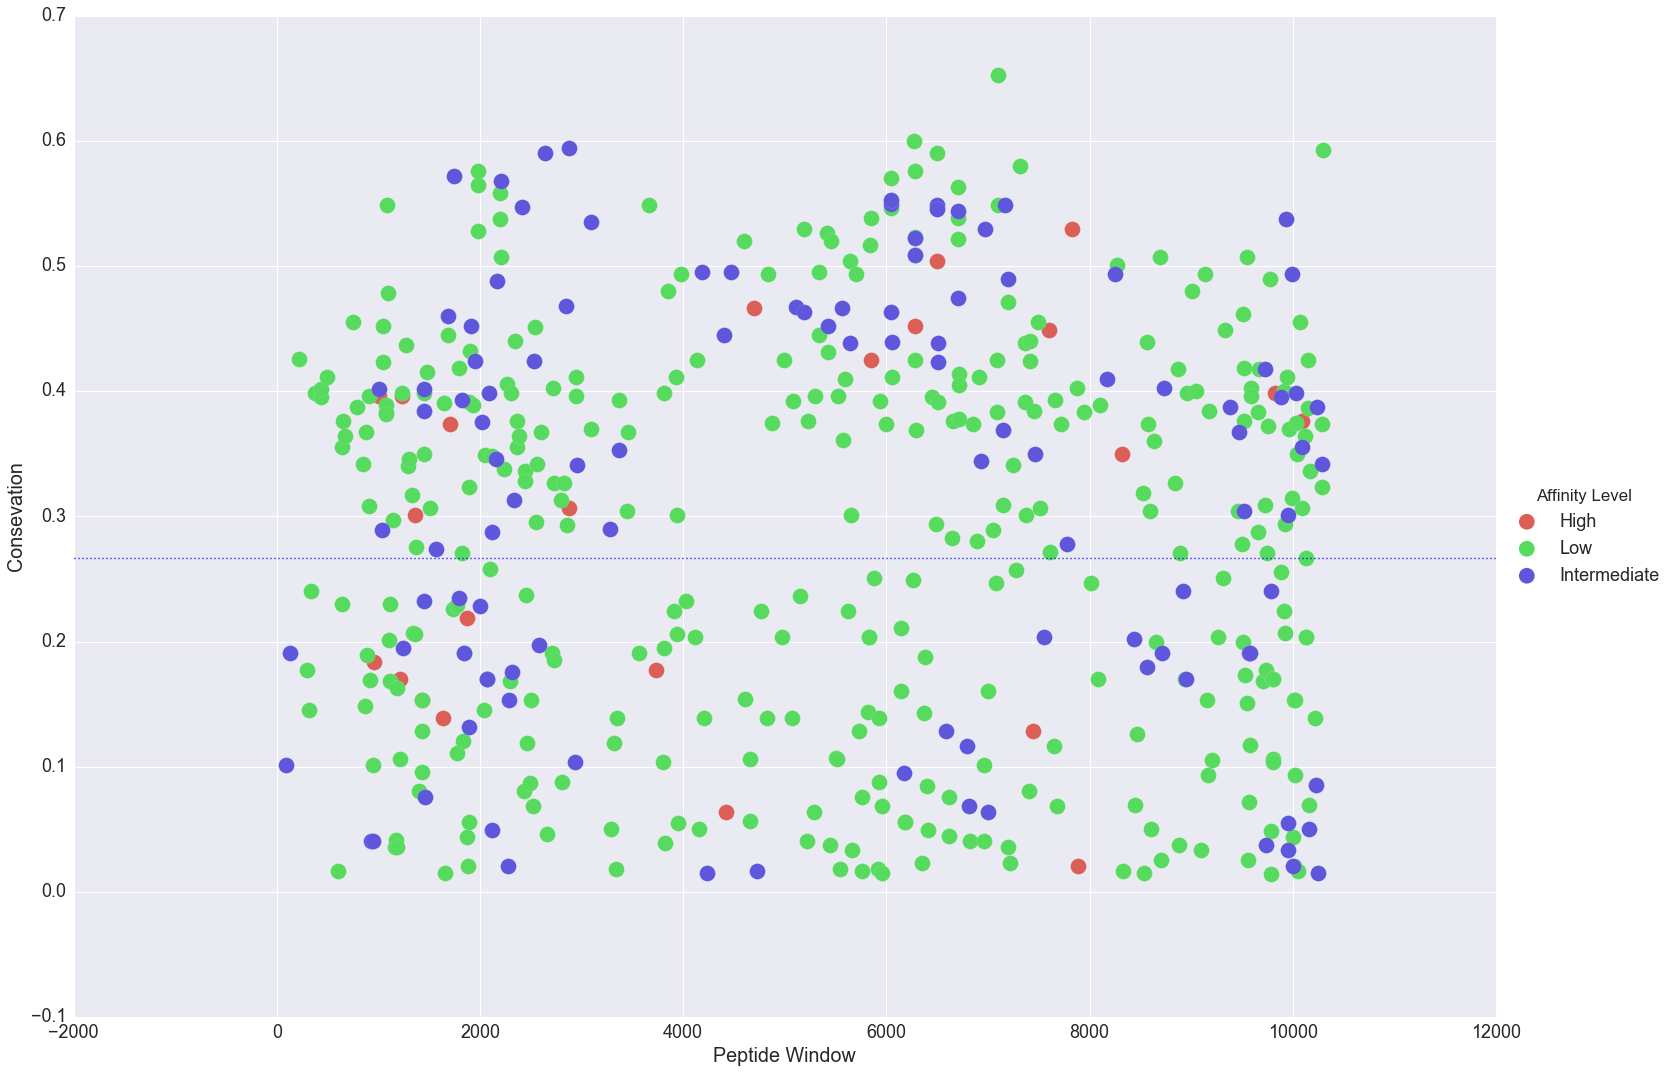

In [13]:
from nepitope import summary_data
%matplotlib inline

single_prot = summary_data.SummaryData.summarize_without_blast_dat(scores_and_affinity)
single_prot.plot_affinity_versus_conservation_score()
single_prot.print_table()
allele_list = single_prot.alleles

In [14]:
csv_path = '/Users/carlomazzaferro/Desktop/CCBB_Results_Immune_Stealth_Analysis/summary_protein_data_per_peptide.csv'
single_prot.my_df.to_csv(path_or_buf=csv_path, sep=',')

### The important part: add conservation alignment and high affinity peptide data   

In [15]:
msa_file = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2.fasta'
msa_file_out =  '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC_cons_AFFINITY_added.fasta'
positional_conservation = my_algn.positional_conservation
scores_affinity_df = scores_and_affinity[0]

msa_file_add_data = scoring_utils.AddData(msa_file, msa_file_out, scores_and_affinity[0], 
                                          positional_conservation, all_alleles=True)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:846: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_print['Peptide'] = to_print['Peptide'].str.replace('X', '-')


0.0


/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


0.0
0.0
0.0
0.04454384131
0.04454384131
0.0
0.0
0.0
0.0
0.0


In [16]:
msa_file_add_data.open_files()  ###should be renamed to open_and_write_to_msa. It indeed does both. 

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:846: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_print['Peptide'] = to_print['Peptide'].str.replace('X', '-')


#### Transform in HTML file so that can be opened easily
Vizualise results in MSA alignment file

In [ ]:
#ran from command line
mview -in fasta -ruler on -html head -coloring any /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC_cons_AFFINITY_added.fasta > /Users/carlomazzaferro/Documents/Code/clustal_study_cons_and_aff_added.html

In [34]:
import os
import webbrowser
from urllib import request

url = 'file:{}'.format(request.pathname2url(os.path.abspath("/Users/carlomazzaferro/Documents/Code/clustal_study_cons_and_aff_added.html")))

webbrowser.open(url)

True

>*Circles*: location of high conservation (on line: conservation info)

>*Peptides at the bottom*: location of high-affinity value

## Top 10 swap candidates and their analogues
Since we have the position of the high affinity, low conservation peptides, we can infer from them the potential peptides from other proteins likely to be good swaps. We'll do this by accessing the fasta file containing all protein sequeces. Further, to avoid false positives, we'll consider only Scores of 0 (or very close to 0).

In [19]:
high_aa_low_cons_df = msa_file_add_data.high_affinity_low_cons_df()
high_aa_low_cons_df.sort_values(by='nM').head(10)

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer,Score
6026,0.808,7.94,0.10,2323,KAIV-DLLF,StreptococcusPy,HLA-B58:01,High,9,0.000000
6918,0.804,8.34,0.03,3215,EVVKKMKNY,StreptococcusPy,HLA-A26:01,High,9,0.000000
6748,0.769,12.17,0.12,3045,KELGS-QIL,StreptococcusPy,HLA-B40:01,High,9,0.000000
12794,0.762,13.20,0.07,1688,HHQDLTLLKAL,StreptococcusPy,HLA-B39:01,High,11,0.000000
4899,0.750,14.87,0.80,1196,-LFGNLIAL,StreptococcusPy,HLA-A02:01,High,9,0.000000
2524,0.734,17.68,0.17,2524,LEDIVLTL,StreptococcusPy,HLA-B40:01,High,8,0.000000
2556,0.724,19.81,0.20,2556,REMIEERL,StreptococcusPy,HLA-B40:01,High,8,0.020848
6148,0.717,21.37,0.25,2445,-EDRFNASL,StreptococcusPy,HLA-B40:01,High,9,0.000000
1688,0.710,23.18,0.15,1688,HHQDLTLL,StreptococcusPy,HLA-B39:01,High,8,0.000000
9094,0.706,24.20,0.15,1689,HQDLTLLKAL,StreptococcusPy,HLA-B39:01,High,10,0.000000


In [21]:
#### Save to csv.
csv_path = '/Users/carlomazzaferro/Desktop/top_peptides_of_interest.csv'
high_aa_low_cons_df.to_csv(path_or_buf=csv_path, sep=',')

## Retrieve potential candidates for switching from the original MSA
Good candidates are the ones that overlap with the peptides that display high affinity and low conservation. By selecting peptides from other proteins that are of low affinity, we aim at finding which peptides could potentially replace the ones of high-affinity in order to create a low-affinity protein (thus stealth), but that to the highest extent still mantains its original function.

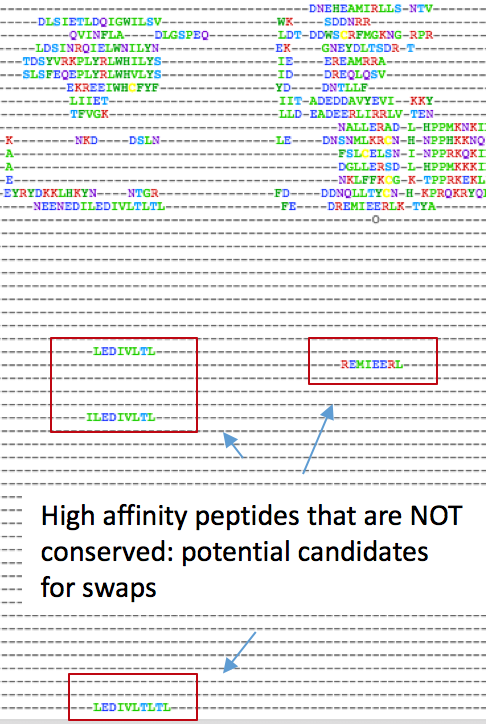

In [97]:
Image("/Users/carlomazzaferro/Desktop/Screen Shot 2016-09-19 at 4.23.53 PM.png")

In [25]:
from nepitope import pep_utils

fasta_file_msa = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_from_dealigned_study_2_MHC.fasta'
fasta_targets = '/Users/carlomazzaferro/Desktop/fasta_targets.fasta'

In [26]:
pepdata = pep_utils.retrieve_orthologue_peptides(fasta_file_msa, high_aa_low_cons_df)
pepdata.sort_values(by='Initial AA').head(7)

,Peptide,n-mer,Protein ID,Initial AA
250,-PSKKMKVL,9,>116628213_StreptococcusthermophilusLMDX9,40
272,-PAKKMKVL,9,>24379809_StreptococcusmutansUA159,40
273,-PAKKMKVL,9,>24379809_StreptococcusmutansUA159,40
360,-PAFKFKVL,9,>422884106_StreptococcussanguinisSK49,40
361,-PAFKFKVL,9,>422884106_StreptococcussanguinisSK49,40
294,-PSKKFKVL,9,>13622193_StreptococcuspyogenesSF370,40
295,-PSKKFKVL,9,>13622193_StreptococcuspyogenesSF370,40


In [100]:
pep_utils.write_fasta_targets_out(pepdata, fasta_targets)

### Send file to netMHCcons and retrieve results

In [28]:
from nepitope import scoring_utils
nmers = [8, 9,10,11]

#files saved from netMHCcons as split_*i*_prediction_*n*_mer for each split/nmer
filepath = '/Users/carlomazzaferro/Desktop/predictions_peptides_swap.xls'

aggregate_all = scoring_utils.FileConsolidation.load_full_file(filepath)

In [60]:
df1 = aggregate_all.return_df_list()
df1 = df1.loc[df1['nM'] > 5000]
lsss = aggregate_all.list_df_by_prot(df1)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:608: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['Affinity Level'] = df1.apply(lambda row: self.label_affinity(row), axis=1)
/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/scoring_utils.py:532: SettingWithCopyWarning: 
A value is tryin

In [66]:
out_csv = '/Users/carlomazzaferro/Desktop/predictions_peptides_swap.csv'
df1.loc[df1['Allele'] == 'HLA-A01:01'].to_csv(path_or_buf=out_csv, sep=',')